<a href="https://colab.research.google.com/github/Yash-Kamtekar/Special-Topics-Assignment-2/blob/main/Node_classification_using_GAT_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

     |████████████████████████████████| 435 kB 19.7 MB/s 
     |████████████████████████████████| 500 kB 55.5 MB/s 
     |████████████████████████████████| 121 kB 6.1 MB/s 
     |████████████████████████████████| 1.6 MB 5.9 MB/s 
     |████████████████████████████████| 83 kB 1.2 MB/s 
     |████████████████████████████████| 41 kB 268 kB/s 


In [2]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

**Data Preparation**

**Loading the CORA Network(Cora is a citation network which is a directed graph)**

In [3]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

**Printing the information of the loaded graph**

In [4]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


**There are seven subjects and we aim at predicting "subject" feature on the nodes**

In [5]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


**Splitting the data into training and test data**

**Here we're taking 180 node labels for training, 460 for validation, and the rest for testing.**

In [6]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=180, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=460, test_size=None, stratify=test_subjects
)

In [7]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,54
Probabilistic_Methods,28
Genetic_Algorithms,28
Theory,23
Case_Based,20
Reinforcement_Learning,15
Rule_Learning,12


**We will use one-hot vectors that will be compared against the model's soft-max output for categorical data. To do this conversion we can use the LabelBinarizer transform from scikit-learn**

In [8]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

**Creating the GCN Layers**

**GCN is a model which is used for Node Classification which is done with the help of FullBatchNodeGenerator**

In [9]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [10]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [11]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

**To create a Keras model we now expose the input and output tensors of the GCN model for node prediction**

In [12]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 16) dtype=float32 (created by layer 'gather_indices')>

In [13]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

**Training the model**

In [14]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Keeping track of the validation set**

In [15]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [17]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 4s - loss: 1.9305 - acc: 0.2833 - val_loss: 1.8815 - val_acc: 0.3043 - 4s/epoch - 4s/step
Epoch 2/200
1/1 - 0s - loss: 1.8758 - acc: 0.3056 - val_loss: 1.8213 - val_acc: 0.3065 - 109ms/epoch - 109ms/step
Epoch 3/200
1/1 - 0s - loss: 1.7939 - acc: 0.3056 - val_loss: 1.7558 - val_acc: 0.3065 - 163ms/epoch - 163ms/step
Epoch 4/200
1/1 - 0s - loss: 1.6949 - acc: 0.3056 - val_loss: 1.6893 - val_acc: 0.3065 - 108ms/epoch - 108ms/step
Epoch 5/200
1/1 - 0s - loss: 1.6343 - acc: 0.3222 - val_loss: 1.6245 - val_acc: 0.3087 - 112ms/epoch - 112ms/step
Epoch 6/200
1/1 - 0s - loss: 1.5490 - acc: 0.3278 - val_loss: 1.5569 - val_acc: 0.3348 - 84ms/epoch - 84ms/step
Epoch 7/200
1/1 - 0s - loss: 1.4660 - acc: 0.3611 - val_loss: 1.4886 - val_acc: 0.3913 - 88ms/epoch - 88ms/step
Epoch 8/200
1/1 - 0s - loss: 1.3787 - acc: 0.4389 - val_loss: 1.4223 - val_acc: 0.4109 - 118ms/epoch - 118ms/step
Epoch 9/200
1/1 - 0s - loss: 1.2682 - acc: 0.4444 - val_loss: 1.3613 - val_acc: 0.4326 - 107ms/epo

**Plot history to view the metrics like behaviour loss of the trained model**

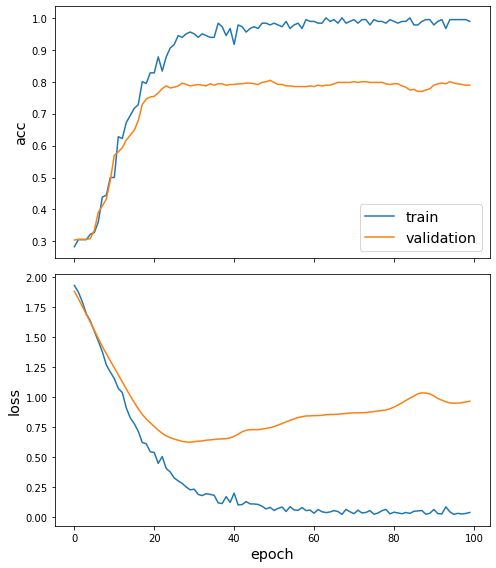

In [18]:
sg.utils.plot_history(history)

**Evaluation of the test dataset**

In [19]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [20]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 51ms/step - loss: 0.7313 - acc: 0.8177

Test Set Metrics:
	loss: 0.7313
	acc: 0.8177


**Performing predictions with the model**

In [21]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

1/1 [==============================] - 0s 142ms/step


In [22]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [23]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Reinforcement_Learning,Probabilistic_Methods
1107140,Theory,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory
